In [37]:
pip install soundfile

In [0]:
import scipy.io.wavfile as wav
import scipy.signal as sig
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import librosa

import librosa.display
from google.colab import files

In [0]:
# load files
# In this script, letters A, B refer to microphones, while indices 1, 2 refers to speakers.
# Microphone A is situated closest to speaker 1, and microphone B is situated closest to
# speaker 2.

sr, x1A = wav.read("/content/1A.wav")
sr, x1B = wav.read("/content/1B.wav")
sr, x2A = wav.read("/content/2A.wav")
sr, x2B = wav.read("/content/2B.wav")
# mixA is the mixture in microphone A, mixB for microphone B.
sr, mixA = wav.read("/content/mixA.wav")
sr, mixB = wav.read("/content/mixB.wav")

x1A = x1A.astype('float')
x1B = x1B.astype('float')
x2A = x2A.astype('float')
x2B = x2B.astype('float')
mixA = mixA.astype('float')
mixB = mixB.astype('float')

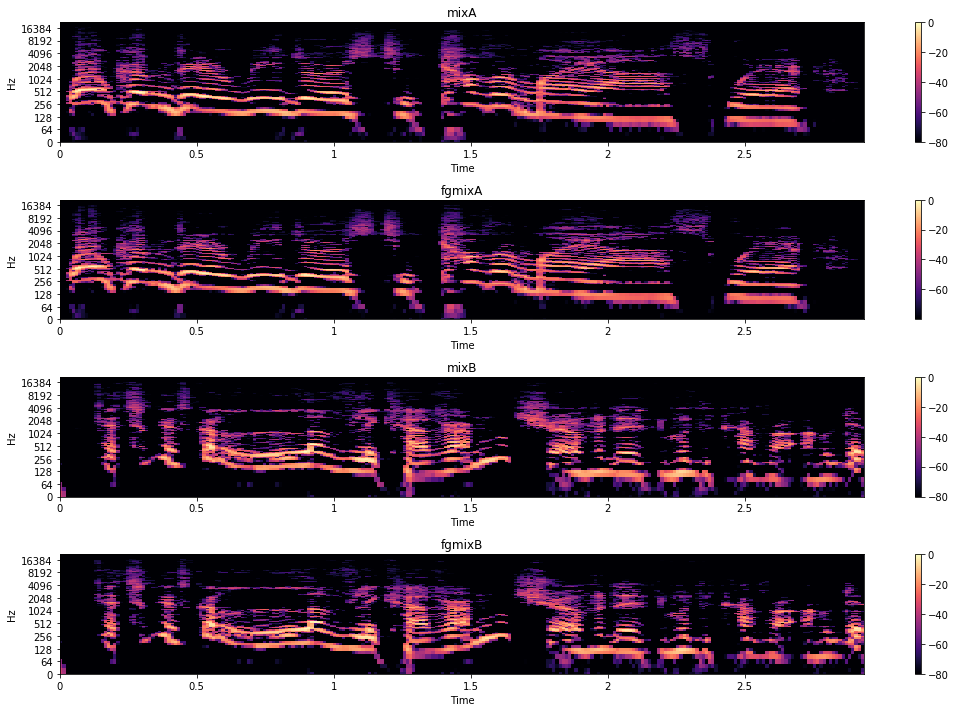

slice(0, 430, None)


In [0]:
S1A, phase1A = librosa.magphase(librosa.stft(x1A))
S2B, phase2B = librosa.magphase(librosa.stft(x2B))
SmixA, phasemixA = librosa.magphase(librosa.stft(mixA))
SmixB, phasemixB = librosa.magphase(librosa.stft(mixB))
clip_length_in_seconds = len(mixB)/sr

# I'm not sure what the first argument to librosa.time_to_frames() should be.
S_filter1A = librosa.decompose.nn_filter(S1A,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(1, sr=sr)))
S_filter2B = librosa.decompose.nn_filter(S2B,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(1, sr=sr)))

# The output of the filter shouldn't be greater than the input.
S_filter1A = np.minimum(S1A, S_filter1A)
S_filter2B = np.minimum(S2B, S_filter2B)

# We can also use a margin to reduce bleed between the vocals and instrumentation masks.
# Jonas: not sure what this means. However, it helps with removing clipping sounds.
# It does alter the voices a little bít sometimes.
margin_v = 5
power = 2

mask_v1A = librosa.util.softmask(S1A - S_filter1A,
                               margin_v * S_filter1A,
                               power=power)

mask_v2B = librosa.util.softmask(S2B - S_filter2B,
                               margin_v * S_filter2B,
                               power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components

# mask_v1A and mask_v2B are ground truths when training our network.
S_fg1A = mask_v1A * S1A
S_fg2B = mask_v2B * S2B

S_fgmixA = mask_v1A * SmixA
S_fgmixB = mask_v2B * SmixB

def istft(self, mag, phase):
    stft_matrix = mag * np.exp(1j*phase)
    return librosa.istft(stft_matrix,
                          hop_length=self.hp.audio.hop_length,
                          win_length=self.hp.audio.win_length)

# write the separated vocals as wav files.

y_fgmixA = librosa.istft(S_fgmixA*np.exp(1j*phasemixA)).astype('int16')
wav.write('y_fgmixA.wav',sr,y_fgmixA)
y_fgmixB = librosa.istft(S_fgmixB*np.exp(1j*phasemixB)).astype('int16')
wav.write('y_fgmixB.wav',sr,y_fgmixB)

# plots
plt.figure(figsize=(15, 10))
plt.subplot(4,1,1)
librosa.display.specshow(librosa.amplitude_to_db(S_fgmixA, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('mixA')
plt.colorbar()
plt.subplot(4,1,2)
librosa.display.specshow(librosa.amplitude_to_db(S_fg1A, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('fgmixA')
plt.colorbar()
plt.subplot(4,1,3)
librosa.display.specshow(librosa.amplitude_to_db(S_fgmixB, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('mixB')
plt.colorbar()
plt.subplot(4,1,4)
librosa.display.specshow(librosa.amplitude_to_db(S_fg2B, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('fgmixB')
plt.colorbar()
plt.tight_layout()
plt.show()
print(idx)